In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import seaborn as sns

sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
from tqdm import tqdm

#TODO: RESNET50 needs different learningrate than resnet18!!!
# I'll get back to this once I have the usability tag sorted out. 


In [ ]:
#important, this is needed to make it work on unsupported RX 6700XT card
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['ROCM_PATH'] = '/opt/rocm'

#os.system('export HSA_OVERRIDE_GFX_VERSION=10.3.0')
#os.system('export ROCM_PATH=/opt/rocm')

In [3]:
use_bbox = True    #run the model/training with bounding boxes when available? 

In [4]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

Connection established


In [5]:
# Image directory
basedir = config['settings']['image_directory']

In [6]:
distinct_brands = db.execute_query('SELECT distinct(brand) FROM listings')

In [7]:
brands = pd.DataFrame(distinct_brands)

In [8]:
BRANDS = brands['brand']


In [9]:

def bbox_to_ints(df):
    df = df.copy()
    for col in ['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']:
        df[col] = df[col].astype(int)
    return df

In [10]:
# Query data
tags = db.execute_query("""SELECT
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path, 
                            listings.brand
                        FROM images 
                        JOIN listings ON listings.id = images.listing_id
                        WHERE 
                            listings.countrycode = 'B' """)
labeled_data = pd.DataFrame(tags).fillna(-1)
labeled_data = bbox_to_ints(labeled_data)


In [11]:
labeled_data["image_path"] = labeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
labeled_data["abs_image_path"]= basedir + '/' + labeled_data["image_path"]

In [12]:
len(labeled_data)

1354804

In [13]:
labeled_data.sample(5)

yolobox_top_left_x  yolobox_top_left_y  yolobox_bottom_right_x  \
514117                   -1                  -1                      -1   
939570                   24                 228                     369   
1054683                  -1                  -1                      -1   
126514                    0                  91                     649   
138051                   48                 116                     612   

         yolobox_bottom_right_y  \
514117                       -1   
939570                      485   
1054683                      -1   
126514                      512   
138051                      444   

                                                image_path          brand  \
514117   mercedes-benz/S-Klasse (alle)/21641b53-36c1-40...  mercedes-benz   
939570   mini/3/5 Deurs/9ffc0cdb-c110-4311-a9ee-8eac79e...           mini   
1054683  kia/Carens/fa85207d-9a33-41c8-9305-4f27b7b7a55...            kia   
126514   skoda/Octavia/7ea00ab3-934b-41b8-8ef5-09375789...          skoda   
138051   skoda/Fabia/ab73042d-5d02-43d3-9393-d9ef10916e...          skoda   

                                            abs_image_path  
514117   /home/frederic/Documents/automotive_image_data...  
939570   /home/frederic/Documents/automotive_image_data...  
1054683  /home/frederic/Documents/automotive_image_data...  
126514   /home/frederic/Documents/automotive_image_data...  
138051   /home/frederic/Documents/automotive_image_data...

In [14]:
brand_encoder = LabelEncoder()
labeled_data['brand_numid'] = brand_encoder.fit_transform(labeled_data['brand'])  # Encode labels as numbers - pytorch is happy now s o me too :)
num_classes = len(brand_encoder.classes_)

In [15]:
brand_encoder.classes_

array(['alfa-romeo', 'alpine', 'audi', 'bmw', 'citroen', 'dacia', 'fiat',
       'ford', 'honda', 'hyundai', 'jeep', 'kia', 'land-rover', 'lexus',
       'lotus', 'mazda', 'mercedes-benz', 'mini', 'nissan', 'opel',
       'peugeot', 'porsche', 'renault', 'seat', 'skoda', 'subaru',
       'suzuki', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [16]:
smallerset = 0.05   #scale down labeled data to a fraction of the original: 
labeled_data = labeled_data.sample(frac=smallerset)

In [17]:
len(labeled_data)

67740

In [18]:
# Custom Dataset for Online Loading
class ImageDataset(Dataset):
    def __init__(self, dataframe, use_bbox, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.usebbox = use_bbox

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['abs_image_path'] 
        label = self.dataframe.iloc[idx]['brand_numid']
        x1 = self.dataframe.iloc[idx]['yolobox_top_left_x']
        y1 = self.dataframe.iloc[idx]['yolobox_top_left_y']
        x2 = self.dataframe.iloc[idx]['yolobox_bottom_right_x']
        y2 = self.dataframe.iloc[idx]['yolobox_bottom_right_y']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.usebbox and x1 != -1:
            image = image.crop((x1, y1, x2, y2))
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [19]:

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224 for pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [20]:

# Initialize Dataset and DataLoader
batch_size = 64
dataset = ImageDataset(labeled_data, use_bbox, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [21]:
# Define Model (Using a Pretrained Model)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(labeled_data['brand'].unique()))  # Adjust output layer for classes
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print('USING GPU ACCELERATION')
else:
    print('USING CPU')

USING GPU ACCELERATION


In [22]:

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Online Training Loop
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [24]:

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {epoch_loss/len(dataloader):.4f}')


/home/frederic/Documents/automotive_project/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/5, Batch 1/1059, Loss: 3.5458
Epoch 1/5, Batch 2/1059, Loss: 3.4690
Epoch 1/5, Batch 3/1059, Loss: 3.1438
Epoch 1/5, Batch 4/1059, Loss: 3.5145
Epoch 1/5, Batch 5/1059, Loss: 3.3300
Epoch 1/5, Batch 6/1059, Loss: 3.0558
Epoch 1/5, Batch 7/1059, Loss: 3.1677
Epoch 1/5, Batch 8/1059, Loss: 2.9478
Epoch 1/5, Batch 9/1059, Loss: 3.3882
Epoch 1/5, Batch 10/1059, Loss: 3.2260
Epoch 1/5, Batch 11/1059, Loss: 3.0420
Epoch 1/5, Batch 12/1059, Loss: 2.8875
Epoch 1/5, Batch 13/1059, Loss: 3.2431
Epoch 1/5, Batch 14/1059, Loss: 3.1263
Epoch 1/5, Batch 15/1059, Loss: 3.3104
Epoch 1/5, Batch 16/1059, Loss: 3.3956
Epoch 1/5, Batch 17/1059, Loss: 3.0127
Epoch 1/5, Batch 18/1059, Loss: 2.9157
Epoch 1/5, Batch 19/1059, Loss: 3.2213
Epoch 1/5, Batch 20/1059, Loss: 3.3834
Epoch 1/5, Batch 21/1059, Loss: 3.1743
Epoch 1/5, Batch 22/1059, Loss: 3.3060
Epoch 1/5, Batch 23/1059, Loss: 2.9402
Epoch 1/5, Batch 24/1059, Loss: 3.0680
Epoch 1/5, Batch 25/1059, Loss: 3.1886
Epoch 1/5, Batch 26/1059, Loss: 2.

In [25]:

# Save Model
torch.save(model.state_dict(), '../../models/pytorch/brand_predictor2.pth')
print("Training complete and model saved.")

Training complete and model saved.


In [36]:
##use the saved model to make random predictions: 
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 30)
model.load_state_dict(torch.load('../../models/pytorch/brand_predictor2.pth'))

/tmp/ipykernel_21491/1308227136.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../models/pytorch/brand_predictor2.pth'))


RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked". 
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for fc.weight: copying a param with shape torch.Size([30, 2048]) from checkpoint, the shape in current model is torch.Size([30, 512]).

In [27]:
model.eval()  #set the model to evaluation mode? #TODO: check if this is necessary in final pipeline

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
random_testdata = db.execute_query("""SELECT
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path, 
                            listings.brand
                        FROM images 
                        JOIN listings ON listings.id = images.listing_id
                        WHERE 
                            listings.countrycode = 'F' """)
labeled_data_random = pd.DataFrame(random_testdata).fillna(-1)
labeled_data_random = bbox_to_ints(labeled_data_random)
#model was trained on a random sample of cars listed in B(elgium); 
#to make sure we test on unseen data; get a sample fo all cars lsited in F(rance)

In [29]:
len(labeled_data_random)

1229702

In [30]:
random_selection = 500000
random_images_to_predict = labeled_data_random.sample(random_selection)
random_images_to_predict["image_path"] = random_images_to_predict["image_path"].apply(lambda x: x.replace('\\', '/'))
random_images_to_predict["abs_image_path"]= basedir + '/' + random_images_to_predict["image_path"]

In [31]:
results = []
for row in random_images_to_predict.iterrows():
    
    #make a function that does the image preprocessing like you fed it into the pytorch model: 
    # Example path to an image
    row = row[1]
    img_path = row['abs_image_path'] 
    label = row['brand']
    x1 = row['yolobox_top_left_x']
    y1 = row['yolobox_top_left_y']
    x2 = row['yolobox_bottom_right_x']
    y2 = row['yolobox_bottom_right_y']
    
    # Load image
    image = Image.open(img_path).convert('RGB')
    #BBOX was used on training, so here too:
    if use_bbox and x1 != -1:
        image = image.crop((x1, y1, x2, y2))
    # Apply transformations if any
    # We'll reuse the SAME transformation as before! see the cell where transform is declared. 
    image = transform(image)

    # Add an extra batch dimension since the model expects a batch of images (even if it's just one)
    image = image.unsqueeze(0)  # Shape: [1, 3, 224, 224]

    #make prediciton: 
    with torch.no_grad():  # Disable gradient calculation (faster, no backpropagation needed)
        output = model(image)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, 1)
    predicted_label = brand_encoder.classes_[predicted_class.item()]
    certainty = probabilities[0, predicted_class].item()
    results.append([img_path, label, predicted_label, certainty])

In [32]:
results = pd.DataFrame(results, columns=['image_path', 'brand', 'prediction', 'certainty'])

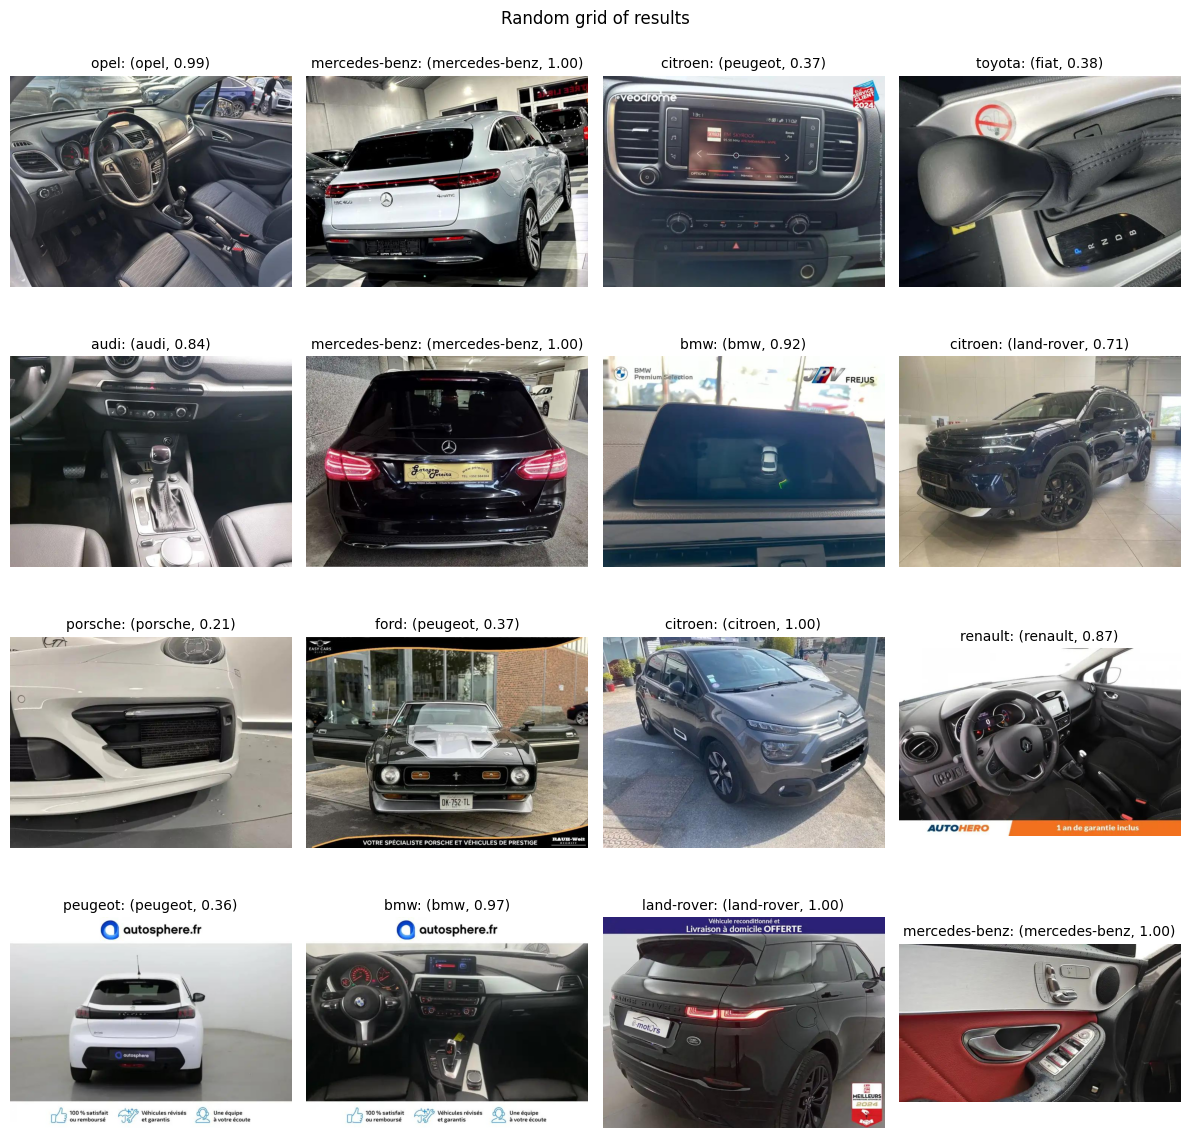

In [33]:
x,y= [4,4]
fig, axes = plt.subplots(x, y, figsize=(12, 12))
axes = axes.flatten()

for i, (index, row) in enumerate(results.sample(x*y).iterrows()):
    image_path = row['image_path']
    brand = row['brand']
    prediction = row['prediction']
    certainty = row['certainty']
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{brand}: ({prediction}, {certainty:.2f})", fontsize=10)
    axes[i].axis('off')
plt.suptitle('Random grid of results')
plt.tight_layout()
plt.show()

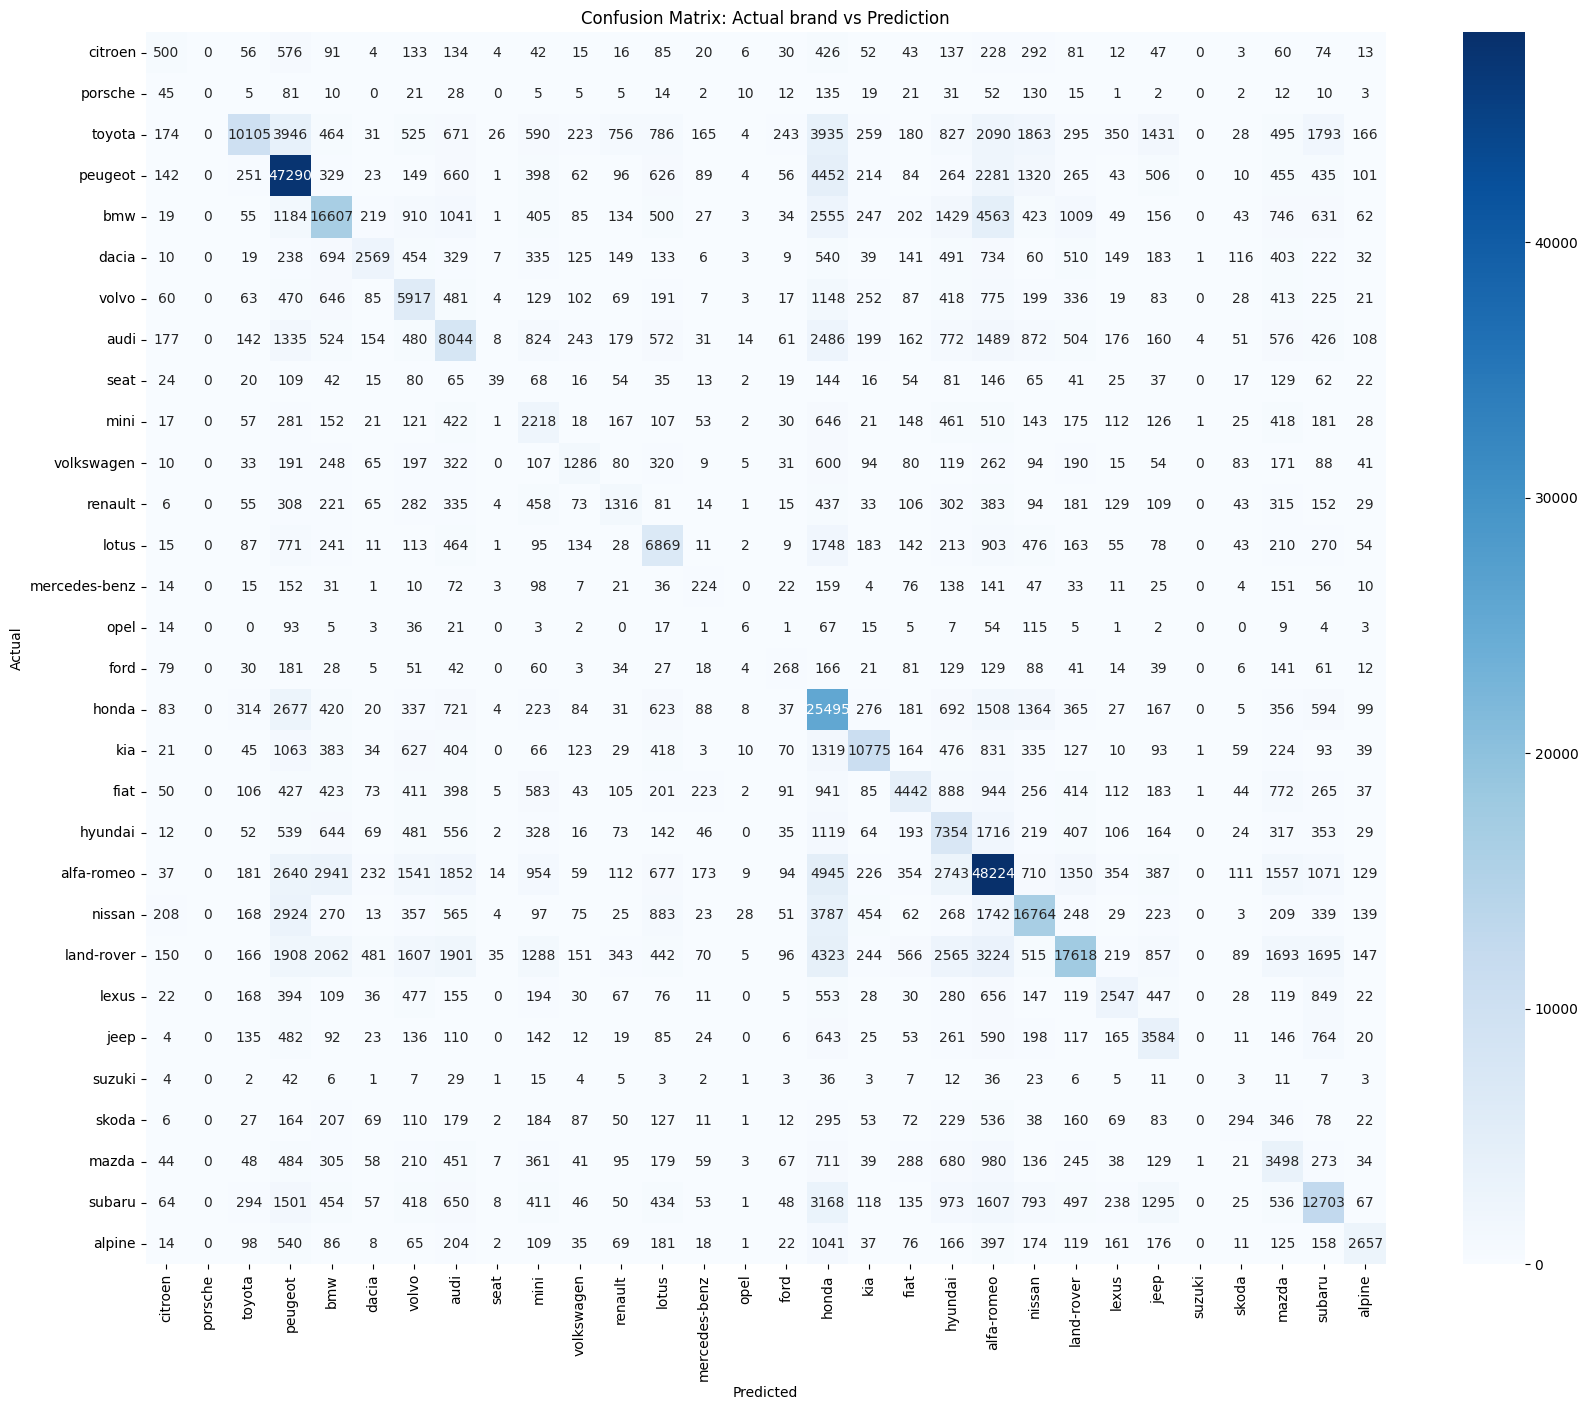

In [34]:
confusion = confusion_matrix(results['brand'], results['prediction'])
plt.figure(figsize=(20, 16))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=results['brand'].unique(), yticklabels=results['brand'].unique())
plt.title('Confusion Matrix: Actual brand vs Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

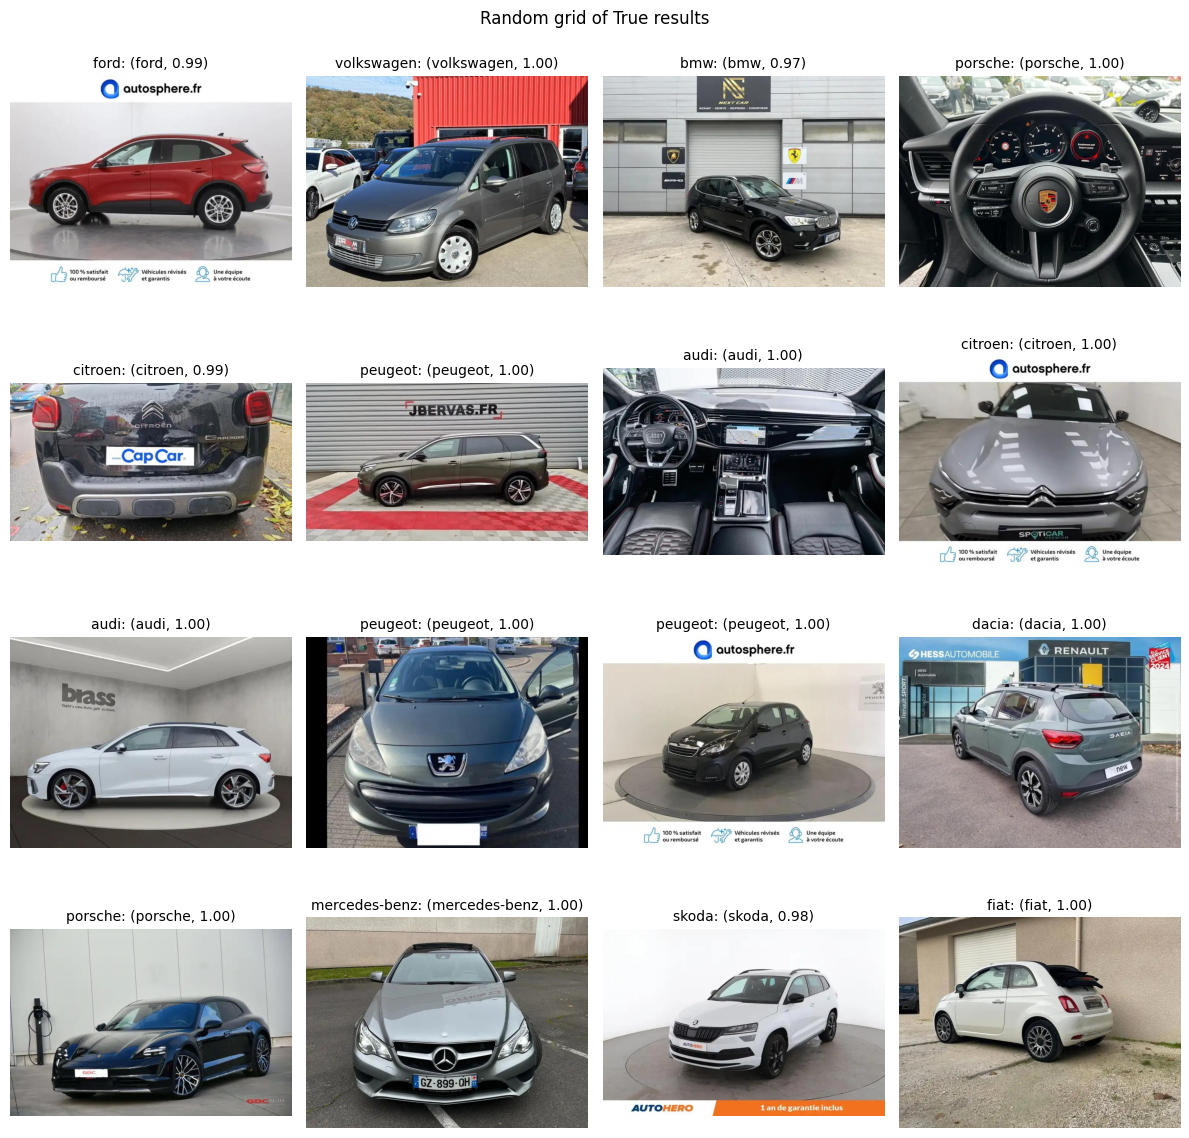

In [35]:
fig, axes = plt.subplots(x, y, figsize=(12, 12))
axes = axes.flatten()

for i, (index, row) in enumerate(results.loc[(results['brand'] == results['prediction']) & (results['certainty'] >= 0.9)].sample(x*y).iterrows()):
    image_path = row['image_path']
    brand = row['brand']
    prediction = row['prediction']
    certainty = row['certainty']
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{brand}: ({prediction}, {certainty:.2f})", fontsize=10)
    axes[i].axis('off')
plt.suptitle('Random grid of True results')
plt.tight_layout()
plt.show()

# Horrible results.

Question for you: WHY?
- Tip: What kind of preprocessing have I forgotten?